In [1]:
!nvidia-smi

Fri Jan  2 21:35:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:06:00.0 Off |                    0 |
| N/A   34C    P0             35W /  250W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [36]:
import numpy as np
import xarray as xr
filename = 'datasets/full_processed/BallSqueezingHD_modified/sub-176/sub-176_task-BallSqueezing_run-1_nirs_right_143.nc'

# Load the data from the .nc file
xr.open_dataarray(filename)

<xarray.DataArray (parcel: 103, chromo: 2, time: 87)> Size: 143kB
[17922 values with dtype=float64]
Coordinates:
  * parcel   (parcel) object 824B 'ContA_IPS_2_LH' ... 'TempPar_8_LH'
  * time     (time) float64 696B 251.5 251.6 251.7 251.9 ... 261.1 261.3 261.4
    samples  (time) int32 348B ...
  * chromo   (chromo) object 16B 'HbO' 'HbR'

In [3]:
import os
import numpy as np
import xarray as xr
import pickle
import glob
import warnings
from pathlib import Path, PureWindowsPath
import re

import cedalion
import cedalion.sigproc.motion as motion_correct
import cedalion.sigproc.quality as quality
import cedalion.sigproc.physio as physio
import cedalion.dot as dot
import cedalion.nirs as nirs
from cedalion.io.forward_model import load_Adot
from cedalion import units

warnings.filterwarnings("ignore")

In [4]:
def get_bad_ch_mask(int_data):
    # Saturated and Dark Channels

    dark_sat_thresh = [1e-3, 0.84]
    amp_threshs_sat = [0., dark_sat_thresh[1]]
    amp_threshs_low = [dark_sat_thresh[0], 1]
    _, amp_mask_sat = quality.mean_amp(int_data, amp_threshs_sat)
    _, amp_mask_low = quality.mean_amp(int_data, amp_threshs_low)
    _, snr_mask = quality.snr(int_data, 10)
    amp_mask=amp_mask_sat & amp_mask_low

    _, list_bad_ch = quality.prune_ch(int_data, [amp_mask, snr_mask], "all")
   
    return list_bad_ch

In [5]:

def standardize_trial_types(DATASET_NAME: str, file: str, rec):
    
    if DATASET_NAME == "FreshMotor":
        # map trial types to left or right depending on the name of the file
        m = re.search(r'(?i)(left|right)', file)

        # rename from MOTOR to left/right
        rec.stim.trial_type = m.group(1).lower()
    
    else:
        mapping = {
            "Right": "right", # BallSqueezingHD
            "Left": "left",   # BallSqueezingHD
            "ElectricalVAS7": "right", # TODO: Electrical_Thermal
            "ElectricalVAS3": "left",  # TODO: Electrical_Thermal
        }
        rec.stim["trial_type"] = rec.stim["trial_type"].replace(mapping)

    return rec

In [6]:
subset_type = "full" # "subset_2"

In [9]:
base_path = "/home/orabe/fNIRS_sparseToDense/"

# Available datasets:
DATASET_NAME = "BallSqueezingHD_modified"
# DATASET_NAME = "FreshMotor"
# DATASET_NAME = "BS_Laura"
# DATASET_NAME = "ElectricalThermal"

raw_path = Path(f'datasets/raw/{DATASET_NAME}')
pre_processed_path = Path(f'datasets/{subset_type}_pre_processed/{DATASET_NAME}')

pre_processed_path.mkdir(parents=True, exist_ok=True)

In [10]:
if DATASET_NAME == "BallSqueezingHD_modified":
    raw_dir = f"{raw_path}/sub-*/nirs/sub-*.snirf"

elif DATASET_NAME == "BS_Laura":
    raw_dir = f"{raw_path}/sub-*/nirs/sub-*.snirf"
    
elif DATASET_NAME == "Electrical_Thermal":
    raw_dir = f"{raw_path}/sub-*/ses-*/nirs/sub-*_ses-*_task-Electrical*_nirs.snirf"
    # TODO: exclude subjects without txt files for landmarks coords
    
elif DATASET_NAME == "FreshMotor":
    duration = "*" # * to include both 2s and 3s
    raw_dir = f"{raw_path}/sub-*/ses-*{duration}/nirs/sub-*_ses-*{duration}_task-FRESHMOTOR_nirs.snirf"
else:
    raise ValueError("Unknown dataset name")

files = glob.glob(raw_dir)

# TODO: to be confirmed
# remove non-BS files for Laura's dataset to avoid errors
if DATASET_NAME == "BS_Laura":
    files = [p for p in files if "BS" in os.path.basename(p)]
    
files = sorted(files)
print(f"{len(files)} files found.")

35 files found.


In [12]:
with open(f"results/subset/{DATASET_NAME}/subsets_data.pkl", "rb") as f:
    subsets_data = pickle.load(f)
subset_channels = subsets_data[subset_type]["all"]
print(len(subset_channels))
# subset_channels

100


In [13]:
filename = files[0] # select one
rec = cedalion.io.read_snirf(filename)[0]  # read snirf files

# subset the data
rec['amp'] = rec['amp'].sel(channel=subset_channels)

# subset measurement list
meas_list = rec._measurement_lists["amp"]
meas_list = meas_list[meas_list["channel"].isin(subset_channels)].reset_index(drop=True)

# both should then be equal
print(f'Number of channels in rec["amp"]: {len(set(rec["amp"].channel.values))}')
print(f'Number of channels in meas_list: {len(set(meas_list.channel.values))}')

head_icbm152 = dot.get_standard_headmodel('icbm152')  
geo3d_snapped_ijk = head_icbm152.align_and_snap_to_scalp(rec.geo3d)

fwm = cedalion.dot.forward_model.ForwardModel(
    head_icbm152, 
    geo3d_snapped_ijk,
    meas_list
)

fluence_fname = os.path.join(pre_processed_path, "fluence_" + DATASET_NAME + ".h5")
sensitivity_fname = os.path.join(pre_processed_path, "sensitivity_" + DATASET_NAME + ".h5")

# compute fluence and sensitivity only once
fwm.compute_fluence_mcx(fluence_fname)
fwm.compute_sensitivity(fluence_fname, sensitivity_fname)

Adot = load_Adot(sensitivity_fname)

recon = dot.ImageRecon(
    Adot,
    recon_mode="mua2conc",
    brain_only=True,
    alpha_meas=10,
    alpha_spatial=10e-3,
    apply_c_meas=True,
    spatial_basis_functions=None,
)

Number of channels in rec["amp"]: 100
Number of channels in meas_list: 100
simulating fluence for S1. 1 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S2. 2 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S3. 3 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S4. 4 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S5. 5 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S6. 6 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S7. 7 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S8. 8 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S9. 9 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S10. 10 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S11. 11 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S12. 12 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S13. 13 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S14. 14 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D1. 15 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D2. 16 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D3. 17 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D4. 18 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D5. 19 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D6. 20 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D7. 21 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D8. 22 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D9. 23 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D10. 24 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D11. 25 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D12. 26 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D13. 27 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D14. 28 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D15. 29 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D16. 30 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D17. 31 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D18. 32 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D19. 33 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D20. 34 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D21. 35 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D22. 36 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D23. 37 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D24. 38 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D25. 39 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D26. 40 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D27. 41 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D28. 42 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D29. 43 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D30. 44 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D31. 45 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D32. 46 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

In [14]:
print(len(meas_list['channel']))
print(rec["amp"].channel.size)
print(recon._F.shape)

200
100
(2, 100, 100)


In [15]:
subject_to_rec = {}
skipped_subjects = []

for f in files:
    records = cedalion.io.read_snirf(f)
    rec = records[0]

    # select subset channels
    rec['amp'] = rec['amp'].sel(channel=subset_channels)

    rec.stim = rec.stim.sort_values(by="onset") ## Yuanyuan dataset

    rec['rep_amp'] = quality.repair_amp(rec['amp'], median_len=3, method='linear')  # Repair Amp
    rec['od_amp'], baseline= nirs.cw.int2od(rec['rep_amp'],return_baseline=True)

    # motion correct [TDDR + WAVELET]
    rec["od_tddr"] = motion_correct.tddr(rec["od_amp"])
    rec["od_tddr_wavel"] = motion_correct.wavelet(rec["od_tddr"])

    #-----------------------------------------highpass filter--------------------------------
    rec['od_hpfilt'] = rec['od_tddr_wavel'].cd.freq_filter(fmin=0.008,fmax=0,butter_order=4)
    #----------------------------------------------------------------------------------------

    # clean amplitude data
    rec['amp_clean'] = cedalion.nirs.cw.od2int(rec['od_hpfilt'], baseline)

    # get bad channel mask
    list_bad_ch = get_bad_ch_mask(rec["amp_clean"]) # this has custom paramerers!? 
    print('the list of bad channels: ', len(list_bad_ch))

    # channel variance
    od_var_vec = quality.measurement_variance(rec["od_hpfilt"], list_bad_channels=list_bad_ch, bad_rel_var=1e6,calc_covariance=False)

    #---------------------------------------------------------------------------------------
    dpf = xr.DataArray(
        [6, 6],
        dims="wavelength",
        coords={"wavelength": rec["amp"].wavelength},
    )
    rec['conc'] = cedalion.nirs.cw.od2conc(rec['od_hpfilt'], rec.geo3d, dpf, spectrum="prahl")

    # conc_pr vs conc 
    chromo_var = quality.measurement_variance(rec['conc'], list_bad_channels = list_bad_ch, bad_rel_var = 1e6, calc_covariance = False)
    rec['conc_pcr'], gb_comp_rem = physio.global_component_subtract(rec['conc'],ts_weights=1/chromo_var,k=0,spatial_dim='channel',spectral_dim='chromo')

    rec['od_pcr1'] = cedalion.nirs.cw.conc2od(rec['conc_pcr'], rec.geo3d, dpf, spectrum="prahl")#     delta_conc = chunked_eff_xr_matmult(od_stacked, B, contract_dim="flat_channel", sample_dim="time", chunksize=300)
    c_meas = quality.measurement_variance(rec['od_hpfilt'], list_bad_channels=list_bad_ch, bad_rel_var=1e6,calc_covariance=False)

    delta_conc = recon.reconstruct(rec['od_pcr1'], c_meas) 
    delta_conc.time.attrs["units"] = units.s

    dC_brain = delta_conc.cd.freq_filter(fmin=0.01, fmax=0.5, butter_order=4)
    dC_brain = dC_brain.sel(time=slice(rec.stim.onset.values[0]-3 , rec.stim.onset.values[-1]+13))
    dC_brain = dC_brain.where(dC_brain.is_brain == True)
    # alternatively use 1/conc_var to weight vertex sensitivity and then normalize by sum of weights
    dC_brain = dC_brain.pint.quantify().pint.to("uM").pint.dequantify()

    hbr = dC_brain.sel(chromo='HbR').groupby('parcel').mean()
    hbo = dC_brain.sel(chromo='HbO').groupby('parcel').mean()
    signal_raw = xr.concat([hbo, hbr], dim='chromo')

    # revised matrix
    signal_raw = signal_raw.sel(parcel=signal_raw.parcel != 'Background+FreeSurfer_Defined_Medial_Wall_LH')
    signal_raw = signal_raw.sel(parcel=signal_raw.parcel != 'Background+FreeSurfer_Defined_Medial_Wall_RH')
    
    delta_conc, global_comp = physio.global_component_subtract(
        signal_raw, 
        ts_weights=None, k=0, 
        spatial_dim='parcel',
        spectral_dim= 'chromo')

    delta_conc = delta_conc / np.abs(delta_conc).max()
    delta_conc = delta_conc.fillna(0)
    delta_conc = delta_conc.transpose("time", "parcel", "chromo")

    parcel_dOD, parcel_mask = fwm.parcel_sensitivity(
        Adot,
        [], # list_bad_ch,
        dOD_thresh = 0.001,       
        minCh=1,
        dHbO=10,
        dHbR=-3
    )
    sensitive_parcels = parcel_mask.where(parcel_mask, drop=True)["parcel"].values.tolist()
    dropped_parcels = parcel_mask.where(~parcel_mask, drop=True)["parcel"].values.tolist()
    print(f"Number of sensitive parcels: {len(sensitive_parcels)}")
    print(f"Number of dropped parcels: {len(dropped_parcels)}")
    
    rec = standardize_trial_types(DATASET_NAME, f, rec)
    
    data = {
        'conc_pcr': rec['conc_pcr'],
        'delta_conc': delta_conc,
        'rec_stim': rec.stim,
        'sensitive_parcels': sensitive_parcels,
    }
    
    # save as pickle (all parcels!!!)
    path = PureWindowsPath(f)
    subject_dir = path.parts[-3]
    filename = path.stem

    if DATASET_NAME == "FreshMotor":
        subject_dir = path.parts[-4]
        session_label = path.parts[-3]
        task_fragment = next(
            (part for part in filename.split('_') if part.startswith('task-')),
            f"task-{DATASET_NAME.replace('_', '').upper()}",
        )
        run_fragment = session_label.replace('ses-', 'run-')
        filename = f'{subject_dir}_{task_fragment}_{run_fragment}_nirs'

    if subject_dir not in subject_to_rec:
        subject_to_rec[subject_dir] = []

    all_parcels_dir = pre_processed_path / subject_dir
    all_parcels_dir.mkdir(parents=True, exist_ok=True)

    file_name_to_save = all_parcels_dir / f'{filename}.pkl'

    with open(file_name_to_save, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

if skipped_subjects:
    print(f"Skipped {len(skipped_subjects)} file(s) because all channels were bad.")

print("Processing complete.")

the list of bad channels:  7
Number of sensitive parcels: 109
Number of dropped parcels: 493
the list of bad channels:  7
Number of sensitive parcels: 109
Number of dropped parcels: 493
the list of bad channels:  17
Number of sensitive parcels: 109
Number of dropped parcels: 493
the list of bad channels:  17
Number of sensitive parcels: 109
Number of dropped parcels: 493
the list of bad channels:  17
Number of sensitive parcels: 109
Number of dropped parcels: 493
the list of bad channels:  6
Number of sensitive parcels: 109
Number of dropped parcels: 493
the list of bad channels:  6
Number of sensitive parcels: 109
Number of dropped parcels: 493
the list of bad channels:  5
Number of sensitive parcels: 109
Number of dropped parcels: 493
the list of bad channels:  2
Number of sensitive parcels: 109
Number of dropped parcels: 493
the list of bad channels:  2
Number of sensitive parcels: 109
Number of dropped parcels: 493
the list of bad channels:  2
Number of sensitive parcels: 109
Numbe

In [16]:
# load data for visualization
subject_name = 'sub-185'
file_name = f'{subject_name}_task-BallSqueezing_run-3_nirs.pkl'

file_to_plot = pre_processed_path / subject_name / file_name

# load data
with open(file_to_plot, 'rb') as handle:
    data = pickle.load(handle)

In [17]:
data['delta_conc']

<xarray.DataArray (time: 4216, parcel: 601, chromo: 2)> Size: 41MB
array([[[-4.05908075e-08,  9.75691305e-09],
        [-1.56787384e-08,  2.72136209e-09],
        [-1.55369224e-06,  2.80247312e-07],
        ...,
        [ 4.85027436e-09,  2.83160546e-09],
        [-9.27547822e-11,  1.11459260e-11],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[-4.46242529e-08,  1.31197493e-08],
        [-1.75260545e-08,  3.44477984e-09],
        [-1.54833454e-06,  3.00876818e-07],
        ...,
        [ 4.74543688e-09,  3.19270646e-09],
        [-9.05289243e-11,  1.25001673e-11],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[-4.79659815e-08,  1.58777634e-08],
        [-1.90591345e-08,  4.02436577e-09],
        [-1.53244729e-06,  3.17930357e-07],
        ...,
...
        ...,
        [ 1.21136919e-09, -1.20198109e-09],
        [-2.50669356e-11,  2.96192893e-11],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[ 1.73164900e-09,  2.11345641e-08],
        [ 1.59758461e-09,  6.54025292e-09],
        [-2.70292968e-07,  2.98824553e-07],
        ...,
        [ 1.04444837e-09, -8.70769828e-10],
        [-2.35718409e-11,  2.80950497e-11],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[ 4.40405706e-09,  1.96142762e-08],
        [ 3.78273537e-09,  5.10385229e-09],
        [-2.59231293e-07,  2.78199435e-07],
        ...,
        [ 8.46989483e-10, -5.35090690e-10],
        [-2.24765645e-11,  2.64034023e-11],
        [ 0.00000000e+00,  0.00000000e+00]]], shape=(4216, 601, 2))
Coordinates:
  * chromo   (chromo) <U3 24B 'HbO' 'HbR'
  * time     (time) float64 34kB 12.96 13.07 13.19 13.3 ... 496.1 496.3 496.4
    samples  (time) int64 34kB 113 114 115 116 117 ... 4324 4325 4326 4327 4328
  * parcel   (parcel) object 5kB 'ContA_Cingm_1_LH' ... 'scalp'

In [19]:
data.keys()

dict_keys(['conc_pcr', 'delta_conc', 'rec_stim', 'sensitive_parcels'])

# Calculate block averages in optical density



In [20]:
data['conc_pcr']

<xarray.DataArray 'concentration' (chromo: 2, channel: 100, time: 4448)> Size: 7MB
<Quantity([[[-4.10481886e-02 -2.80087684e-01 -3.85385854e-01 ... -1.77094771e-01
   -2.26599672e-01 -1.96473262e-01]
  [-7.78392694e-02 -2.74432780e-01 -4.18285090e-01 ... -1.59078013e-01
   -2.07839467e-01 -1.35085831e-01]
  [ 3.22155615e-02  1.54064621e-01  1.23714236e-01 ... -4.33089977e-01
   -4.82538969e-01 -2.70280990e-01]
  ...
  [-5.00786972e-02  1.41232097e-01  5.23918780e-03 ...  1.24642495e-02
    3.94552651e-02  5.97901133e-03]
  [ 2.96624749e-02 -1.56237140e-02 -2.32068415e-02 ...  7.48271770e-02
   -2.18206102e-04  1.05959773e-01]
  [-3.56017087e-02  1.38380697e-01 -3.72931576e-03 ...  4.10002887e-02
    9.97159283e-02  4.63255445e-02]]

 [[ 6.67898476e-02 -2.32425704e-01 -2.06578711e-01 ...  2.34654983e-01
    1.84294735e-01  1.75736673e-01]
  [ 5.48190724e-03 -1.32800380e-01 -1.35140629e-01 ... -5.89016825e-02
   -1.11811168e-01 -4.00812440e-02]
  [ 3.74206189e-02  7.13192793e-02  1.58663449e-01 ...  3.52300577e-01
    3.18732327e-01  2.00034774e-01]
  ...
  [ 2.58083712e-02  8.00416656e-03  5.09298930e-02 ...  1.03616941e-02
    1.46342943e-02  3.66123650e-03]
  [ 5.77991798e-02  5.40866240e-02  8.46171519e-02 ... -2.44027438e-01
   -1.54099812e-01  1.03828730e-02]
  [ 2.38096233e-02  2.79572160e-02  7.59023437e-02 ...  5.77995106e-02
    3.80802339e-02  2.63515252e-02]]], 'micromolar')>
Coordinates:
  * chromo    (chromo) <U3 24B 'HbO' 'HbR'
  * time      (time) float64 36kB 0.0 0.1147 0.2294 0.3441 ... 509.8 509.9 510.0
    samples   (time) int64 36kB 0 1 2 3 4 5 6 ... 4442 4443 4444 4445 4446 4447
  * channel   (channel) object 800B 'S1D1' 'S1D2' 'S1D4' ... 'S14D31' 'S14D32'
    source    (channel) object 800B 'S1' 'S1' 'S1' 'S1' ... 'S14' 'S14' 'S14'
    detector  (channel) object 800B 'D1' 'D2' 'D4' 'D5' ... 'D29' 'D31' 'D32'

In [21]:
rec['od_pcr1']

<xarray.DataArray 'optical_density' (wavelength: 2, channel: 100, time: 4448)> Size: 7MB
<Quantity([[[ 2.12762149e-03 -1.40475952e-02 -1.46287525e-02 ...  6.95857281e-03
    4.09050213e-03  4.20849522e-03]
  [-9.45455740e-04 -9.33262126e-03 -1.15717011e-02 ... -4.69685359e-03
   -7.51108254e-03 -3.59660336e-03]
  [ 1.82368561e-03  4.76476222e-03  7.55326301e-03 ...  6.92571246e-03
    5.00390925e-03  3.59332871e-03]
  ...
  [ 2.72812451e-04  2.44474398e-03  2.10508570e-03 ...  5.99886376e-04
    1.17622883e-03  2.35675898e-04]
  [ 3.07481770e-03  2.14601321e-03  3.37822045e-03 ... -9.60925926e-03
   -6.86835261e-03  2.24876444e-03]
  [ 4.11006538e-04  3.19373678e-03  2.96181388e-03 ...  2.91505557e-03
    3.01446672e-03  1.74478933e-03]]

 [[ 7.35602491e-05 -1.22506857e-02 -1.47580337e-02 ... -6.74025034e-04
   -3.01127069e-03 -2.31545783e-03]
  [-2.00078199e-03 -9.73234338e-03 -1.36494903e-02 ... -5.32319276e-03
   -7.56852796e-03 -4.34540162e-03]
  [ 1.42319327e-03  5.03973652e-03  5.71086473e-03 ... -5.09556754e-03
   -6.88835881e-03 -3.50540379e-03]
  ...
  [-9.02845969e-04  3.98112278e-03  1.04698965e-03 ...  5.22838792e-04
    1.33239299e-03  2.27549107e-04]
  [ 2.05228620e-03  6.00125195e-04  9.76501382e-04 ... -2.57565969e-03
   -3.07130081e-03  3.43147426e-03]
  [-5.44510808e-04  4.25548182e-03  1.24601098e-03 ...  2.13978791e-03
    3.38481354e-03  1.72622851e-03]]], 'dimensionless')>
Coordinates:
  * wavelength  (wavelength) float64 16B 760.0 850.0
  * time        (time) float64 36kB 0.0 0.1147 0.2294 ... 509.8 509.9 510.0
    samples     (time) int64 36kB 0 1 2 3 4 5 ... 4442 4443 4444 4445 4446 4447
  * channel     (channel) object 800B 'S1D1' 'S1D2' 'S1D4' ... 'S14D31' 'S14D32'
    source      (channel) object 800B 'S1' 'S1' 'S1' 'S1' ... 'S14' 'S14' 'S14'
    detector    (channel) object 800B 'D1' 'D2' 'D4' 'D5' ... 'D29' 'D31' 'D32'

Blockaverage od_pcr1

In [22]:
import matplotlib.pyplot as p

# segment data into epochs
epochs = rec['od_pcr1'].cd.to_epochs(
    rec.stim,  # stimulus dataframe
    ["left", "right"],  # select fingertapping events, discard others
    before=2 * units.s,  # seconds before stimulus
    after=10 * units.s,  # seconds after stimulus
)

# calculate baseline
baseline = epochs.sel(reltime=(epochs.reltime < 0)).mean("reltime")

# subtract baseline
epochs_blcorrected = epochs - baseline

# group trials by trial_type. For each group individually average the epoch dimension
blockaverage_od_pcr1 = epochs_blcorrected.groupby("trial_type").mean("epoch")

In [23]:
from IPython.display import Image
def display_image(fname : str):
    display(Image(data=open(fname,'rb').read(), format='png'))

In [24]:
results_path_prefix = f'results/{subset_type}/{DATASET_NAME}/{subject_name}'
os.makedirs(results_path_prefix, exist_ok=True)

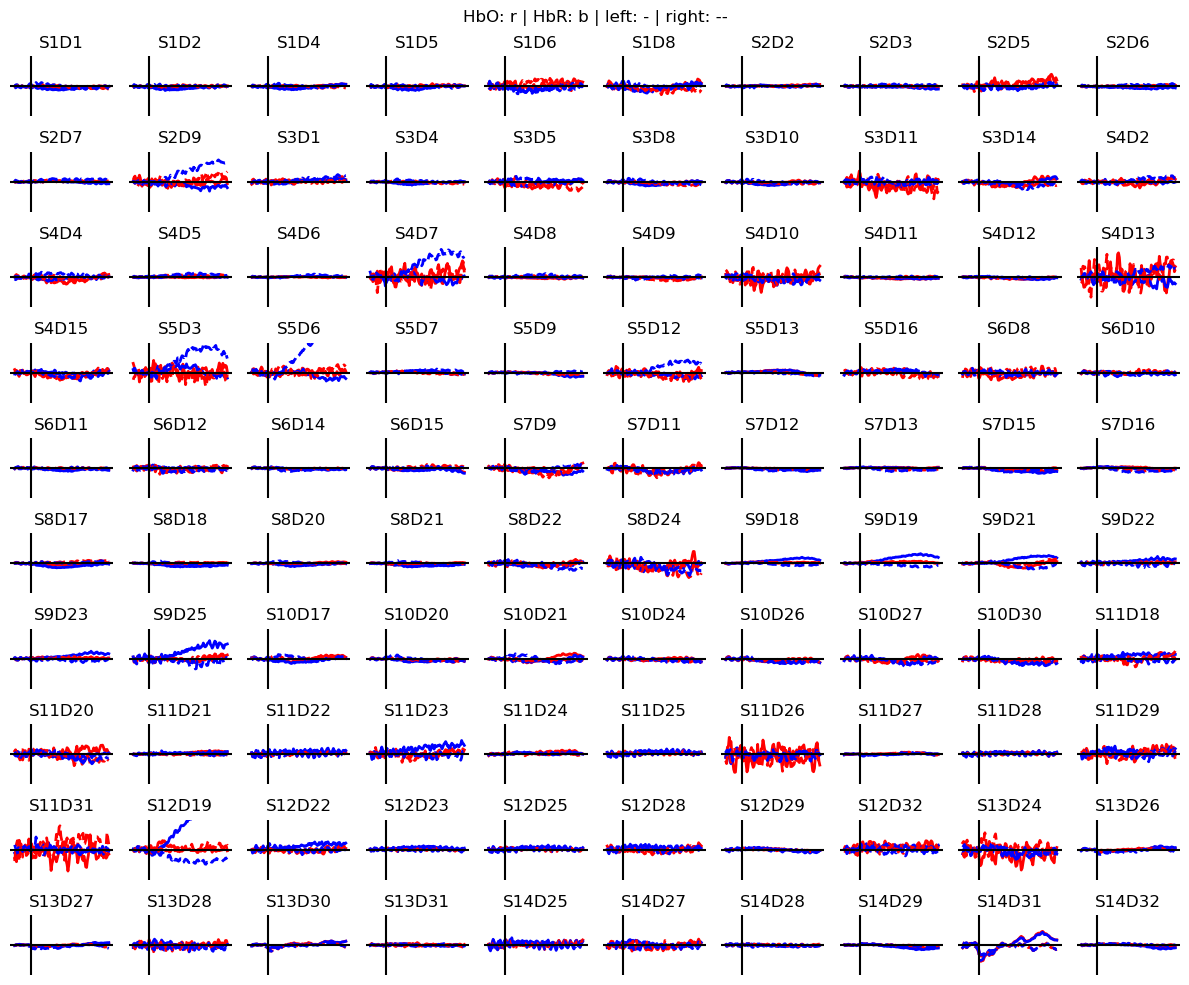

In [25]:
# Plot block averages. Please ignore errors if the plot is too small in the HD case

filename = f"results/{subset_type}/{DATASET_NAME}/blockaverage_channel_space_{subset_type}.png"

noPlts2 = int(np.ceil(np.sqrt(len(blockaverage_od_pcr1.channel))))
f,ax = p.subplots(noPlts2,noPlts2, figsize=(12,10))
ax = ax.flatten()
for i_ch, ch in enumerate(blockaverage_od_pcr1.channel):
    for ls, trial_type in zip(["-", "--"], blockaverage_od_pcr1.trial_type):
        ax[i_ch].plot(blockaverage_od_pcr1.reltime, blockaverage_od_pcr1.sel(wavelength=760, trial_type=trial_type, channel=ch), "r", lw=2, ls=ls)
        ax[i_ch].plot(blockaverage_od_pcr1.reltime, blockaverage_od_pcr1.sel(wavelength=850, trial_type=trial_type, channel=ch), "b", lw=2, ls=ls)

    ax[i_ch].grid(1)
    ax[i_ch].set_title(ch.values)
    ax[i_ch].set_ylim(-.02, .02)
    ax[i_ch].set_axis_off()
    ax[i_ch].axhline(0, c="k")
    ax[i_ch].axvline(0, c="k")

# p.suptitle("760nm: r | 850nm: b | left: - | right: --")
p.suptitle("HbO: r | HbR: b | left: - | right: --")

p.tight_layout()
p.savefig(filename)

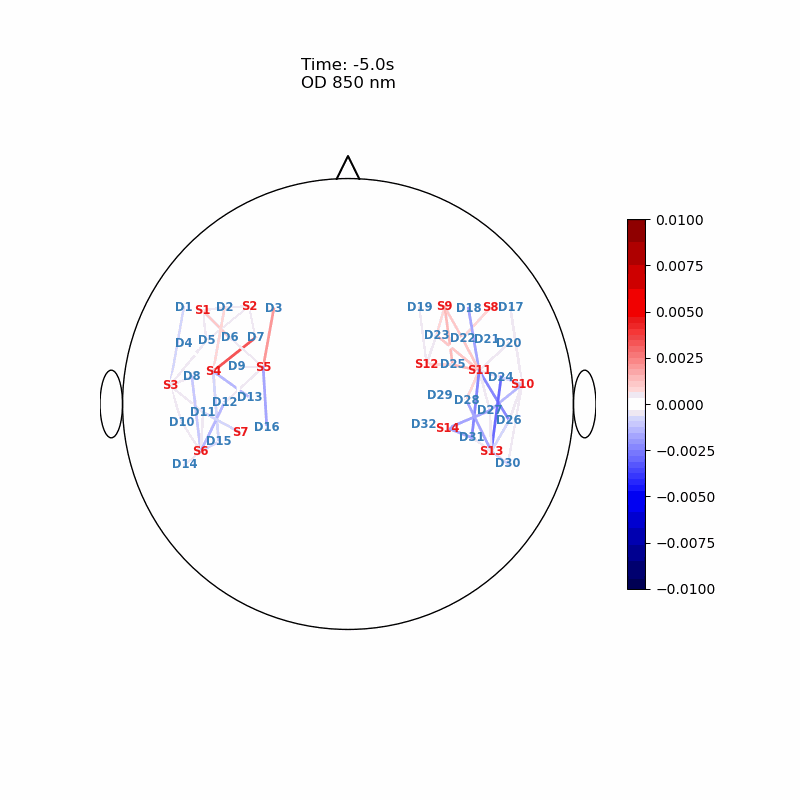

In [26]:
# Viz reconstruction on Channel Space
import cedalion.vis.anatomy
filename_scalp = f"results/{subset_type}/{DATASET_NAME}/scalp_plot_ts_{subset_type}.png"

data_ts = blockaverage_od_pcr1.sel(wavelength=850, trial_type="left")
# scalp_plot_gif expects the time dimension to be named 'time'
data_ts = data_ts.rename({"reltime": "time"})

# call plot function
cedalion.vis.anatomy.scalp_plot_gif(
    data_ts,
    rec.geo3d,
    filename=filename_scalp,
    time_range=(-5, 30, 0.5) * units.s,
    scl=(-0.01, 0.01),
    fps=6,
    optode_size=6,
    optode_labels=True,
    str_title="OD 850 nm",
)
display_image(f"{filename_scalp}.gif")

Blockaverage_delta_conc

In [27]:

# segment data into epochs
epochs = data['delta_conc'].cd.to_epochs(
    rec.stim,  # stimulus dataframe
    ["left", "right"],  # select fingertapping events, discard others
    before=2 * units.s,  # seconds before stimulus
    after=10 * units.s,  # seconds after stimulus
)

# calculate baseline
baseline = epochs.sel(reltime=(epochs.reltime < 0)).mean("reltime")

# subtract baseline
epochs_blcorrected = epochs - baseline

# group trials by trial_type. For each group individually average the epoch dimension
blockaverage_delta_conc = epochs_blcorrected.groupby("trial_type").mean("epoch")

In [28]:
vertex_parcels = head_icbm152.brain.vertex_coords['parcel']
vertex_parcels = np.array(vertex_parcels)

parcel_index = blockaverage_delta_conc.get_index("parcel")  # pandas index
vertex_parcel_idx = parcel_index.get_indexer(vertex_parcels)

parcel_data = blockaverage_delta_conc.values  # shape (2, 107, 601, 2)

# Broadcast using integer indexing on axis=2 (parcel axis)
vertex_activity = parcel_data[:, :, vertex_parcel_idx, :]

n_vertices = len(vertex_parcel_idx)

vertex_da = xr.DataArray(
    vertex_activity,
    dims=("trial_type", "reltime", "vertex", "chromo"),
    coords=dict(
        trial_type=blockaverage_delta_conc.trial_type,
        reltime=blockaverage_delta_conc.reltime,
        chromo=blockaverage_delta_conc.chromo,

        # vertex index
        vertex=np.arange(n_vertices),

        # parcel label of each vertex
        parcel_of_vertex=("vertex", vertex_parcels),

        # NEW: is_brain flag
        is_brain=("vertex", np.ones(n_vertices, dtype=bool))
    )
)

vertex_da.shape

(2, 107, 15002, 2)

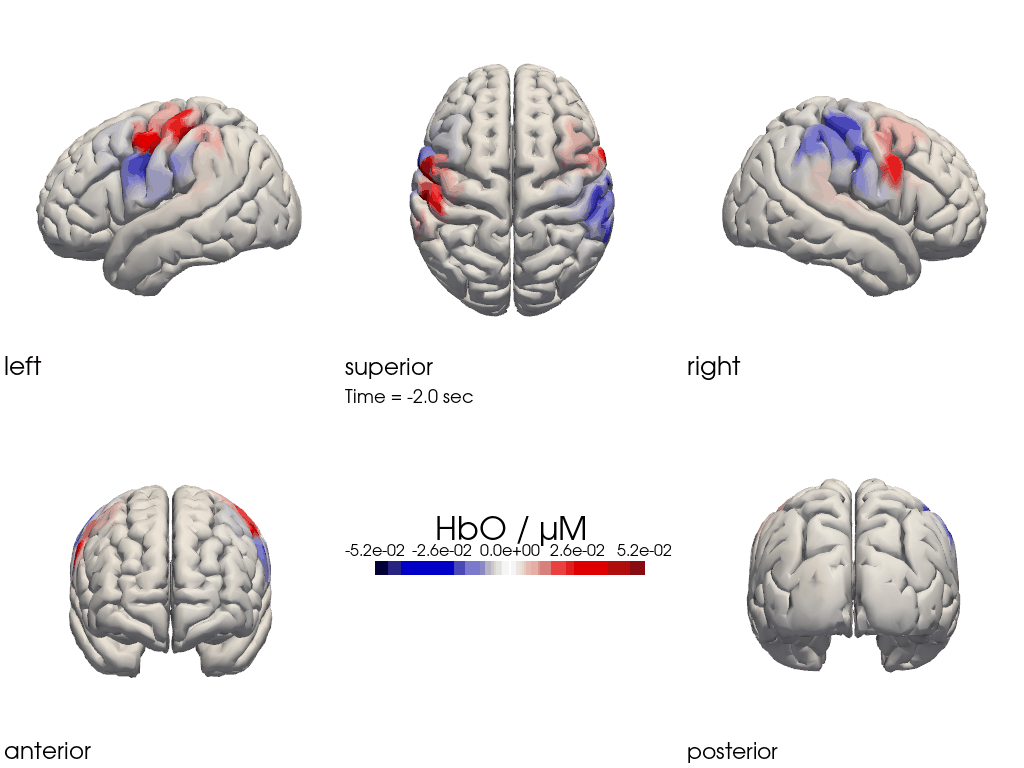

In [29]:



filename_multiview = f'{results_path_prefix}/image_recon_multiview_{subset_type}'

# prepare data
X_ts = vertex_da.sel(trial_type="left").rename({"reltime": "time"})
X_ts = X_ts.transpose("vertex", "chromo", "time")

scl = np.percentile(np.abs(X_ts.sel(chromo='HbO')).pint.dequantify(), 99)
clim = (-scl,scl)

cedalion.vis.anatomy.image_recon_multi_view(
    X_ts,  # time series data; can be 2D (static) or 3D (dynamic)
    head_icbm152,
    cmap='seismic',
    clim=clim,
    view_type='hbo_brain',
    title_str='HbO / µM',
    filename=filename_multiview,
    SAVE=True,
    time_range=(-2,10,0.5)*units.s,
    fps=6,
    geo3d_plot = None, #  geo3d_plot
    wdw_size = (1024, 768)
)
display_image(filename_multiview+'.gif')

# Segmentation

In [30]:
pre_processed_path

PosixPath('datasets/full_pre_processed/BallSqueezingHD_modified')

In [31]:
# load (all) parcel files
preproc_files_path = str(pre_processed_path / 'sub-*' / '*.pkl')
proc_pkl_files = glob.glob(preproc_files_path)

len(proc_pkl_files), proc_pkl_files[:2]

(35,
 ['datasets/full_pre_processed/BallSqueezingHD_modified/sub-181/sub-181_task-BallSqueezing_run-2_nirs.pkl',
  'datasets/full_pre_processed/BallSqueezingHD_modified/sub-181/sub-181_task-BallSqueezing_run-3_nirs.pkl'])

In [32]:
processed_path = Path(f'datasets/{subset_type}_processed/{DATASET_NAME}')
processed_path.mkdir(parents=True, exist_ok=True)

### Create template sensitive parcels

In [34]:
create_orload_parcel_template = "load"  # "load" or "create"

if create_orload_parcel_template == "create":
    # Load any file as all processed files have the same sensitive parcels
    f = f"datasets/{subset_type}_pre_processed/BallSqueezingHD_modified/sub-185/sub-185_task-BallSqueezing_run-1_nirs.pkl"

    with open(f, 'rb') as handle:
        data = pickle.load(handle)
        
    print(len(data['sensitive_parcels']))

    # save the loaded sensitive parcels as template as pkl file
    folder_path = 'datasets/parcel_templates'
    os.makedirs(folder_path, exist_ok=True)
    sens_parcel_template_path = os.path.join(folder_path, f'{subset_type}_parcel_template_subset_2_BallSqueezingHD_modified.pkl')

    with open(sens_parcel_template_path, 'wb') as handle:
        pickle.dump(data['sensitive_parcels'], handle)
        
        
elif create_orload_parcel_template == "load":
    folder_path = 'datasets/parcel_templates'
    
    sens_parcel_template_path = os.path.join(folder_path, 'subset_2_parcel_template_subset_2_BallSqueezingHD_modified.pkl')

    with open(sens_parcel_template_path, 'rb') as handle:
        template_sens_parcel_list = pickle.load(handle)
        
    print(len(template_sens_parcel_list))

103


In [35]:
baseline_duration = 2.5  # in seconds
n_shifts = 9
duration = 10  # in seconds
post_padding = 5  # in seconds
n_timepoints = 87  # fixed length after shifting

if DATASET_NAME == "BallSqueezingHD_modified":
    delta_range = (-2.5, 2.5)
elif DATASET_NAME == "FreshMotor":
    delta_range = (-2.0, 0.0)
start_shift = np.linspace(*delta_range, n_shifts)

    
for file in proc_pkl_files:
    with open(file, 'rb') as handle:
        data_pickle = pickle.load(handle)
    
    
    delta_brain = data_pickle['delta_conc']
    sensitive_parcels = data_pickle['sensitive_parcels']
    rec_stim = data_pickle['rec_stim']

    # [OLD]: Align subject-specific parcels to a common parcel template (zero-pad missing parcels)
    # delta_brain = delta_brain.sel(parcel=sensitive_parcels).reindex(parcel=PARCEL_TEMPLATE, fill_value=0)
    
    # [NEW]: select only parcels in the common template
    delta_brain = delta_brain.sel(parcel=template_sens_parcel_list)
    
    i = 0
    for index, row in rec_stim.iterrows():
        label = row["trial_type"].lower()
        for s in start_shift:
            start_time = row["onset"] + s
            end_time = start_time + duration + post_padding # in seconds
            baseline = delta_brain.sel(
                time=slice(row["onset"] - baseline_duration, row["onset"])
            ).mean("time")
            
            # Then, trimming is easy with `.sel()`:
            x = delta_brain.sel(time=slice(start_time, end_time)) - baseline
            x = x.isel(time=slice(0, n_timepoints))
            x = x.transpose("parcel", "chromo", "time")
            del x.time.attrs['units']

            if not os.path.exists(os.path.dirname(file.replace(str(pre_processed_path), str(processed_path)))):
                os.makedirs(os.path.dirname(file.replace(str(pre_processed_path), str(processed_path))))
            if s == 0:
                x.to_netcdf(file.replace(str(pre_processed_path), str(processed_path)).replace(".pkl", "_" + label + "_"+str(i)+"_test.nc"))
                i += 1
            else:
                x.to_netcdf(file.replace(str(pre_processed_path), str(processed_path)).replace(".pkl", "_" + label + "_"+str(i)+".nc"))
                i += 1

    print("finished processing file: ", os.path.basename(file).replace(".pkl",".npy"))
print('--- Done!---')            

finished processing file:  sub-181_task-BallSqueezing_run-2_nirs.npy
finished processing file:  sub-181_task-BallSqueezing_run-3_nirs.npy
finished processing file:  sub-181_task-BallSqueezing_run-1_nirs.npy
finished processing file:  sub-183_task-BallSqueezing_run-1_nirs.npy
finished processing file:  sub-183_task-BallSqueezing_run-3_nirs.npy
finished processing file:  sub-183_task-BallSqueezing_run-2_nirs.npy
finished processing file:  sub-179_task-BallSqueezing_run-3_nirs.npy
finished processing file:  sub-179_task-BallSqueezing_run-2_nirs.npy
finished processing file:  sub-179_task-BallSqueezing_run-1_nirs.npy
finished processing file:  sub-176_task-BallSqueezing_run-1_nirs.npy
finished processing file:  sub-176_task-BallSqueezing_run-3_nirs.npy
finished processing file:  sub-176_task-BallSqueezing_run-2_nirs.npy
finished processing file:  sub-173_task-BallSqueezing_run-2_nirs.npy
finished processing file:  sub-173_task-BallSqueezing_run-1_nirs.npy
finished processing file:  sub-173

### channel space

In [ ]:

baseline_duration = 2.5  # in seconds
n_shifts = 9
duration = 10  # in seconds
post_padding = 5  # in seconds
n_timepoints = 87  # fixed length after shifting

if DATASET_NAME == "BallSqueezingHD_modified":
    delta_range = (-2.5, 2.5)
elif DATASET_NAME == "FreshMotor":
    delta_range = (-2.0, 0.0)
start_shift = np.linspace(*delta_range, n_shifts)

    
for file in proc_pkl_files:
    with open(file, 'rb') as handle:
        data_pickle = pickle.load(handle)
    
    
    rec_stim = data_pickle['rec_stim']
    conc_pcr = data_pickle['conc_pcr'] # channel space data

    # Align subject-specific parcels to a common parcel template (zero-pad missing parcels)
    # delta_brain = delta_brain.sel(parcel=sensitive_parcels).reindex(parcel=PARCEL_TEMPLATE, fill_value=0)
    
    i = 0
    for index, row in rec_stim.iterrows():
        label = row["trial_type"].lower()
        for s in start_shift:
            start_time = row["onset"] + s
            end_time = start_time + duration + post_padding # in seconds
            
            # channel space baseline
            baseline_conc_pcr = conc_pcr.sel(
                time=slice(row["onset"] - baseline_duration, row["onset"])
            ).mean("time")
        
            # channel space segment
            x_channel = conc_pcr.sel(time=slice(start_time, end_time)) - baseline_conc_pcr
            x_channel = x_channel.isel(time=slice(0, n_timepoints))
            x_channel = x_channel.transpose("channel", "chromo", "time")

            # print(x_channel.shape)
            del x_channel.time.attrs['units']
            if not os.path.exists(os.path.dirname(file.replace(str(pre_processed_path), str(processed_path)))):
                os.makedirs(os.path.dirname(file.replace(str(pre_processed_path), str(processed_path))))
            if s == 0:
                x_channel.to_netcdf(file.replace(str(pre_processed_path), str(processed_path)).replace(".pkl", "_" + label + "_"+str(i)+"_test.nc"))
                i += 1
            else:
                x_channel.to_netcdf(file.replace(str(pre_processed_path), str(processed_path)).replace(".pkl", "_" + label + "_"+str(i)+".nc"))
                i += 1

    print("finished processing file: ", os.path.basename(file).replace(".pkl",".npy"))
print('--- Done!---')            

### Old appraoch using event files and freq0.5

FreshMotor

- parcel space: (parcel: 110, chromo: 2, time: 87)
- channel space: (time: 87, channel: 68, chromo: 2)

---
BallSqueezing

- parcel space: (parcel: 110, chromo: 2, time: 87)
- channel space: (channel: 100, chromo: 2, time: 87)


In [ ]:
# FRESHMOTOR dataset
# load one processed nc file
filename = 'datasets/processed/FreshMotor/sub-01/sub-01_task-FRESHMOTOR_run-left2s_nirs_left_0.nc'
data = xr.load_dataset(filename)
    
# extract np array from xarray and remove first dimension
# data.to_array().squeeze().transpose("channel", "chromo", "time")
data

In [ ]:
type(data)
getattr(data, "dims", None)
[data[v].dims for v in data.data_vars]  # if Dataset



# Outdated approach

In [ ]:
baseline_duration = 2.5  # in seconds
n_shifts = 9
duration = 10  # in seconds
post_padding = 5  # in seconds
n_timepoints = 87  # fixed length after shifting

if DATASET_NAME == "BallSqueezingHD_modified":
    delta_range = (-2.5, 2.5)
elif DATASET_NAME == "FreshMotor":
    delta_range = (-2.0, 0.0)
start_shift = np.linspace(*delta_range, n_shifts)






label_dict = {'right':1, 'left':2}  
subject_to_rec = {}            
INDEX = 0     
freq_dir = processed_path / f'frq{0.5}'
freq_dir.mkdir(exist_ok=True)       
for file in proc_pkl_files:
    with open(file, 'rb') as handle:
        data_pickle = pickle.load(handle)
    
    delta_brain = data_pickle['delta_conc']
    sensitive_parcels = data_pickle['sensitive_parcels']
    rec_stim = data_pickle['rec_stim']

    # Align subject-specific parcels to a common parcel template (zero-pad missing parcels)
    # delta_brain = delta_brain.sel(parcel=sensitive_parcels).reindex(parcel=PARCEL_TEMPLATE, fill_value=0)
    delta_brain = delta_brain.sel(parcel=template_sens_parcel_list)

    i = 0
    
    
    
    
    # ------
    SUB = PureWindowsPath(file).parts[-2]
    if SUB not in subject_to_rec:
        subject_to_rec[SUB] = []
    try:
        sub_dir = Path(freq_dir) / SUB
        sub_dir.mkdir(parents=True, exist_ok=True)
    except FileExistsError:
        pass
    # ------

    for index, row in rec_stim.iterrows():
        label = row["trial_type"].lower()
        for s in start_shift:
            start_time = row["onset"] + s
            end_time = start_time + duration + post_padding # in seconds
            baseline = delta_brain.sel(
                time=slice(row["onset"] - baseline_duration, row["onset"])
            ).mean("time")
            
            # Then, trimming is easy with `.sel()`:
            x = delta_brain.sel(time=slice(start_time, end_time)) - baseline
            x = x.isel(time=slice(0, n_timepoints))
            x = x.transpose("parcel", "chromo", "time")
            del x.time.attrs['units']

            data = {
                'xt': x,
                'file': file,
                'class': label_dict[label],
            }

            # -----
            # save events
            filename = r'{}/{}/event_{}_delta{:+.2f}_{}.pkl'.format(freq_dir, SUB, 'aug' if s != 0.0 else 'orig', s, INDEX)
            subject_to_rec[SUB].append(filename)
            INDEX += 1
            # -----
            
            
            # if not os.path.exists(os.path.dirname(file.replace(str(pre_processed_path), str(processed_path)))):
            #     os.makedirs(os.path.dirname(file.replace(str(pre_processed_path), str(processed_path))))
            # if s == 0:
            #     x.to_netcdf(file.replace(str(pre_processed_path), str(processed_path)).replace(".pkl", "_" + label + "_"+str(i)+"_test.nc"))
            #     i += 1
            # else:
            #     x.to_netcdf(file.replace(str(pre_processed_path), str(processed_path)).replace(".pkl", "_" + label + "_"+str(i)+".nc"))
            #     i += 1
            with open(filename, 'wb') as handle:
                pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
with open('{}/meta_event_{}.pkl'.format(freq_dir, 0.5), 'wb') as handle:
    pickle.dump(subject_to_rec, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('--- Done!---')            
    # print("finished processing file: ", os.path.basename(file).replace(".pkl",".npy"))

In [ ]:
events = "datasets/processed/{}/frq{}/meta_event_{}.pkl"
    
meta_events = []

with open(events.format(DATASET_NAME, 0.5, 0.5), 'rb') as handle:
    meta = pickle.load(handle)
meta_events.append(meta)


if DATASET_NAME == "BallSqueezingHD_modified":
    session_to_files = {'run-1':[],
                        'run-2':[],
                        'run-3':[]}
    
elif DATASET_NAME == "FreshMotor":    
    session_to_files = {'run-left2s':[],
                        'run-right2s':[],
                        'run-left3s':[],
                        'run-right3s':[]}

files_to_session = {}
for meta_event in meta_events:
    for sub in meta_event:
        for file in meta_event[sub]:
            meta = None
            with open(file, 'rb') as handle:
                meta = pickle.load(handle) 
            
            run = meta['file'].split('_')[-2]
            files_to_session[file] = run
            session_to_files[run].append(file)

for run in session_to_files:
    print(run, len(session_to_files[run]))

# this will save the mapping of files to sessions used for LOSO
with open(f'datasets/processed/{DATASET_NAME}/files_to_sessions.pkl', 'wb') as handle:
    pickle.dump(files_to_session, handle, protocol=pickle.HIGHEST_PROTOCOL)     
print("Saved files_to_sessions.pkl")